In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import random
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
from tensorflow.keras.utils import Sequence
from PIL import Image
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
!pip install git+https://github.com/qubvel/efficientnet
!pip install -U efficientnet
from tensorflow.keras.applications import EfficientNetB0

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-dyeeldgx
     |████████████████████████████████| 50 kB 661 kB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18420 sha256=5c1fe516534b895643887ba2e6756dd615afd23f28a2d1e674513ac8726a105e
  Stored in directory: /tmp/pip-ephem-wheel-cache-zd89hwaj/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Requirement already up-to-date: efficientnet in /opt/conda/lib/python3.7/site-packages (1.1.1)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
df=pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')

columns=['SmokingStatus','Sex']
for fitcolumns in columns:
    le = preprocessing.LabelEncoder()
    le.fit(df[fitcolumns])
    df[fitcolumns]=le.transform(df[fitcolumns])
df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,1,1
1,ID00007637202177411956430,5,2214,55.712129,79,1,1
2,ID00007637202177411956430,7,2061,51.862104,79,1,1
3,ID00007637202177411956430,9,2144,53.950679,79,1,1
4,ID00007637202177411956430,11,2069,52.063412,79,1,1


In [4]:
columns=['Percent','Age','Sex','SmokingStatus']
    
for transformcolumns in columns:
    scaler = MinMaxScaler()
    scaler.fit(np.array(df[transformcolumns]).reshape(-1,1))
    df[transformcolumns]=scaler.transform(np.array(df[transformcolumns]).reshape(-1,1)) 
df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,0.236393,0.769231,1.0,0.5
1,ID00007637202177411956430,5,2214,0.215941,0.769231,1.0,0.5
2,ID00007637202177411956430,7,2061,0.184960,0.769231,1.0,0.5
3,ID00007637202177411956430,9,2144,0.201767,0.769231,1.0,0.5
4,ID00007637202177411956430,11,2069,0.186580,0.769231,1.0,0.5


In [5]:
dcm1=pydicom.dcmread('../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/1.dcm')
dcm2=pydicom.dcmread('../input/osic-pulmonary-fibrosis-progression/train/ID00009637202177434476278/100.dcm')
print(dcm1.pixel_array.shape)
print(dcm2.pixel_array.shape)

(512, 512)
(768, 768)


In [6]:
def resize_image(image):
    image=pydicom.dcmread(image).pixel_array
    image=np.stack((image,)*3, axis=-1)
    return cv2.resize(image, dsize=(512,512), interpolation=cv2.INTER_CUBIC)

In [7]:
class IGenerator(Sequence):
    def __init__(self,keys,df,batch_size=32):
        self.keys = [k for k in keys if k not in ['ID00011637202177653955184', 'ID00052637202186188008618']]
        self.df=df
        self.batch_size=batch_size
        self.train_data = {}
        
        for patientid in df.Patient.values:
            self.train_data[patientid] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{patientid}/')
            
    def __len__(self):
        #no of batches per epoch - steps per epoch . If steps per epoch is specified it should be less than the no of 
        #batches per epoch
        return 200
    
    def __getitem__(self,idx):
        
        imagedata=[]
        df=[]
        y=[]
        
        keys = np.random.choice(self.keys, size = self.batch_size)
        
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                image='../input/osic-pulmonary-fibrosis-progression/train/'+str(k)+'/'+str(i)
                image=pydicom.dcmread(image).pixel_array
                image=np.stack((image,)*3, axis=-1)
                image=cv2.resize(image, dsize=(224,224), interpolation=cv2.INTER_CUBIC)
                imagedata.append(image)
                
                x=self.df[self.df['Patient']==k]
                fvc=x[['FVC']]
                x=x[['SmokingStatus','Percent','Sex','Weeks','Age']]
                
                i= random.randint(0,len(x)-1)
                
                df.append(x.iloc[i])
                y.append(fvc.iloc[i])
                
            except:
                pass
       
        imagedata,df ,y = np.array(imagedata), np.array(df) ,np.array(y)
        y=y.reshape(-1,)
        return [imagedata, df] , y

In [8]:
def build_model(input_dim=224):
    input1 = layers.Input(shape=(input_dim,input_dim,3))
    input2=layers.Input(shape=(5,))
    effnet = EfficientNetB0(include_top=False, input_tensor=input1, weights="imagenet")

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(effnet.output)
    x = tf.keras.Model(inputs=input1,outputs=x)
    
    
    
    y= layers.Dense(64,activation='relu')(input2)
    y=tf.keras.Model(inputs=input2,outputs=y)
    
    
    
    
    combined=layers.concatenate((x.output,y.output))
    
    z=layers.Dense(1024,activation='sigmoid')(combined)
    z=layers.Dense(512,activation='sigmoid')(z)
    z=layers.Dense(1,activation='linear')(z)
    
    
    
    model = tf.keras.Model(inputs=[x.input,y.input], outputs=z, name="EfficientNet")
    
    
    #optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    #optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.001)
    optimizer= tf.keras.optimizers.SGD(learning_rate=0.001)
    
    rmse=tf.keras.metrics.RootMeanSquaredError()

    mse = tf.keras.losses.MeanSquaredError()
    model.compile(optimizer=optimizer, loss='mae', metrics='mae')
    
    
    return model

In [9]:
filepath = "./weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=2, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model=build_model(224)
model=tf.keras.models.load_model('../input/osic-b0-trained-weights/OSIC b0 trained weights.hdf5')
#model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), loss='mae', metrics='mae')
#model=tf.keras.models.load_model('./weights.hdf5')

16711680/16705208 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 224, 224, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_2[0][0]            
_______________________________________________________________________________________

In [11]:
key=df['Patient'].unique()

In [12]:
history=model.fit(IGenerator(keys=key,df=df),steps_per_epoch =32,epochs=50,callbacks=callbacks_list,verbose=1)

Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 40.9947 - mean_absolute_error: 40.9947
Epoch 00001: loss improved from inf to 40.99471, saving model to ./weights.hdf5
32/32 [==============================] - 192s 6s/step - loss: 40.9947 - mean_absolute_error: 40.9947
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 40.1154 - mean_absolute_error: 40.1154
Epoch 00002: loss improved from 40.99471 to 40.11545, saving model to ./weights.hdf5
32/32 [==============================] - 185s 6s/step - loss: 40.1154 - mean_absolute_error: 40.1154
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 49.8239 - mean_absolute_error: 49.8239
Epoch 00003: loss did not improve from 40.11545
32/32 [==============================] - 186s 6s/step - loss: 49.8239 - mean_absolute_error: 49.8239
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 40.3344 - mean_absolute_error: 40.3344
Epoch 00004: loss did not improve from 40.11545
32/32 [=

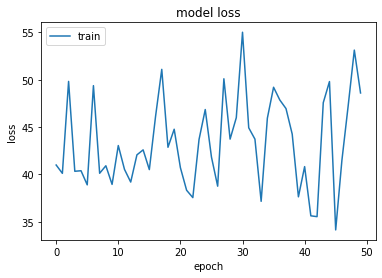

In [13]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [14]:
model.get_weights()

[array([0.485, 0.456, 0.406], dtype=float32),
 array([0.229, 0.224, 0.225], dtype=float32),
 0,
 array([[[[ 2.75408123e-02,  8.26788545e-01, -9.97884810e-01,
            6.62438452e-01, -3.09163127e-02,  4.59883437e-02,
           -6.19226694e-02,  2.67184488e-02, -7.55490124e-01,
           -3.12530637e-01,  2.16864139e-01, -1.13844825e-02,
           -3.90400857e-01, -1.01285195e+00, -1.03297196e-02,
           -6.51510417e-01,  4.75777537e-02,  3.29423010e-01,
            7.34988809e-01,  1.04413196e-01, -3.26552354e-02,
            8.74023199e-01,  1.79132015e-01,  2.64951456e-02,
            1.89874113e-01, -6.21045172e-01,  6.46857098e-02,
            4.31696326e-02, -1.45603448e-01, -1.47961780e-01,
           -1.15873113e-01, -1.53584152e-01],
          [ 1.96644068e-02,  1.53891110e+00, -1.83038652e+00,
            8.60164464e-01,  3.04535590e-03,  2.72885233e-01,
           -1.37177855e-01, -4.10965949e-01,  5.66497028e-01,
           -4.28681225e-01,  8.52434188e-02, -7.6009